In [1]:
# using the rmg code
import rmgpy.molecule as molecule
from IPython.display import display
import time

species has 3 resonance structures:



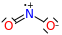

multiplicity 2
1 N u1 p0 c+1 {2,D} {3,S}
2 O u0 p2 c0 {1,D}
3 O u0 p3 c-1 {1,S}



multiplicity 2
1 N u0 p1 c0 {2,D} {3,S}
2 O u0 p2 c0 {1,D}
3 O u1 p2 c0 {1,S}



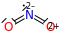

multiplicity 2
1 N u1 p1 c-2 {2,D} {3,D}
2 O u0 p2 c0 {1,D}
3 O u0 p1 c+2 {1,D}

time: 00:00:00


In [3]:
t0 = time.time()   # set timer
#mol = molecule.Molecule(SMILES="CN[NH]")
#mol = molecule.Molecule(SMILES="CO[O]")
#mol = molecule.Molecule(SMILES="C=[C]C(=O)O[O]")
mol = molecule.Molecule(SMILES="O=[N+][O-]")

molList = molecule.resonance.generateResonanceStructures(mol)
print "species has {0} resonance structures:\n".format(len(molList))
for struc in molList:
    #print "{0}".format(struc)
    display(struc)
    print struc.toAdjacencyList()

t1 = time.time() - t0
m, s = divmod(t1, 60)
h, m = divmod(m, 60)
d, h = divmod(h, 24)

print("time: %02d:%02d:%02d"%(h, m, s))

In [ ]:
"N#S" - 1 (23);- time 0
"N#[S]" - 2 (19);- time 0
x"O(N=O)[N]#N" - 1 (900);- time 4 (problematic SMILES, use AdjList)
"C[N+]([NH-])=O" - 1; time 0
"OS(=O)[O]" - 2 (435);- time 0
"[N]=NON=O" - 3 (3539);-  time 3
"[N]=C" - 1;- time 0 (0)
"N=C" - 1 (6);- time 0 (0)
"OS(=O)[O]" - 2;- time 0


running over the N2O resonance

In [ ]:
import os
import unittest
import numpy as np

import rmgpy
import rmgpy.tools.uncertainty as uncertainty
from rmgpy.data.rmg import RMGDatabase
from rmgpy.tools.uncertainty import Uncertainty


uncertainty.Uncertainty.extractSourcesFromModel()






In [ ]:
from rmgpy.molecule.group import ActionError, GroupAtom, GroupBond, Group
from rmgpy.molecule.atomtype import atomTypes
from rmgpy.molecule import Molecule

adjlist = """
1  *1 N1sc u0
"""
answer_smiles = '[NH2-]'
group = Group().fromAdjacencyList(adjlist)
result = group.makeSampleMolecule()

result

In [ ]:
mol = molecule.Molecule(SMILES="[NH-]=[SH+]")
display(mol)
print mol.toAdjacencyList()

In [ ]:

Adj="""
multiplicity 2
1 O u1 p2 c-1 {2,D}
2 N u0 p0 c+1 {1,D} {3,D}
3 O u0 p1 c+1 {2,D} {4,S}
4 N u0 p2 c-3 {3,S} {5,T}
5 N u0 p0 c+2 {4,T}
"""
mol = molecule.Molecule().fromAdjacencyList(Adj)
mol

In [ ]:
# functions

import rmgpy.molecule as molecule
from IPython.display import display


#pathfinder:

def findAllDelocalizationPaths(atom1):
    """
    Find all the delocalization paths allyl to the radical center indicated
    by `atom1`. Used to generate resonance isomers.
    """
    # No paths if atom1 is not a radical
    if atom1.radicalElectrons <= 0:
        return []

    # Find all delocalization paths
    paths = []
    for atom2, bond12 in atom1.edges.items():
        # Vinyl bond must be capable of gaining an order
        if (bond12.isSingle() or bond12.isDouble()) and (atom1.radicalElectrons == 1 or atom1.radicalElectrons == 2):
            for atom3, bond23 in atom2.edges.items():
                # Allyl bond must be capable of losing an order without breaking
                if atom1 is not atom3 and (bond23.isDouble() or bond23.isTriple()):
                    paths.append([atom1, atom2, atom3, bond12, bond23])
    return paths

def findAllDelocalizationPathsLonePairRadicalCharge(atom1):
    """
    Find all the delocalization paths of lone electron pairs next to the radical center indicated
    by `atom1`. Used to generate resonance isomers. Example: NO2
    """
    
    # No paths if atom1 is not a radical
    if atom1.radicalElectrons <= 0:
        return []
    # We currently only consider N/S/O atoms as possible radical centers
    if not ((atom1.isNitrogen() and atom1.lonePairs in [0,1])  # in NO2 N has 0 lone pairs; in HO[NH] N has 1 lone pair
            or (atom1.isOxygen() and atom1.lonePairs in [1,2])      # Eg: NO2 classic, HOS
            or (atom1.isSulfur() and atom1.lonePairs in [0,1,2])):  # S is not restricted like O. Eg: HOSO2, HOSO, HOS
        return []
    
    # Find all delocalization paths
    paths = []
    for atom2, bond12 in atom1.edges.items():
        # Only single bonds are considered
        if bond12.isSingle():
            # atom2 must posses a lone electron pair to loose it
            if ((atom2.isNitrogen() and atom2.lonePairs in [1,2])   # NO2 vs. N2H3
                or (atom2.isOxygen() and atom2.lonePairs in [2,3])  # Eg: NO2, HOS
                or (atom2.isSulfur() and atom2.lonePairs in [1,2,3]))\
                    and (atom2.radicalElectrons == 0):
                paths.append([atom1, atom2])
    return paths

def findAllDelocalizationPathsLonePairMultipleBond(atom1):
    """
    Find all the delocalization paths of a lone electron pair on `atom1`.
    Used to generate resonance isomers. Example: S#N, N#[S], O=S([O])=O, [N]=C, N=C
    """
    paths = []
    for atom2, bond12 in atom1.edges.items():
        if atom2.radicalElectrons == 0:  # we don't want to find adjacent rad paths such as [O][O]
            if bond12.isSingle():
                # Find paths in the direction <forming> the multiple bond
                # atom1 must posses at least one lone pair to loose it
                if ((atom1.isNitrogen() and atom1.lonePairs in [1,2,3])
                        or (atom1.isOxygen() and atom1.lonePairs in [2,3])  # not allowing O with no lonePairs
                        or (atom1.isSulfur() and atom1.lonePairs in [1,2,3])):
                    paths.append([atom1, atom2, bond12, 1])
            elif bond12.isDouble():
                # Find paths in the direction <increasing> the multiple bond
                # atom1 must posses at least one lone pair to loose it
                if ((atom1.isNitrogen() and atom1.lonePairs in [1,2,3])
                        or (atom1.isOxygen() and atom1.lonePairs in [2,3])
                        or (atom1.isSulfur() and atom1.lonePairs in [1,2,3])):
                    paths.append([atom1, atom2, bond12, 1])
                # Find paths in the direction <decreasing> the multiple bond
                # atom1 gains a lone pair, hence cannot have more than two lone pairs
                if ((atom1.isNitrogen() and atom1.lonePairs in [0,1,2])
                        or (atom1.isOxygen() and atom1.lonePairs in [1,2])
                        or (atom1.isSulfur() and atom1.lonePairs in [0,1,2])):
                    paths.append([atom1, atom2, bond12, 2])
            elif bond12.isTriple():
                # Find paths in the direction <decreasing> the multiple bond
                # atom1 gains a lone pair, hence cannot have more than two lone pairs
                if ((atom1.isNitrogen() and atom1.lonePairs in [0,1,2])
                        or (atom1.isOxygen() and atom1.lonePairs in [1,2])
                        or (atom1.isSulfur() and atom1.lonePairs in [0,1,2])):
                    paths.append([atom1, atom2, bond12, 2])
    return paths

def findAllDelocalizationPathsN5dd_N5ts(atom1):
    """
    Find all the resonance structures of nitrogen atoms with two double bonds (N5dd)
    and nitrogen atoms with one triple and one single bond (N5ts)
    """
    # No paths if atom1 is not nitrogen
    if not (atom1.isNitrogen()):
        return []
    
    # Find all delocalization paths
    paths = []
    index_atom_2 = 0
    index_atom_3 = 0
    
    for atom2, bond12 in atom1.edges.items():
        index_atom_2 = index_atom_2 + 1
        # Only double bonds are considered
        if bond12.isDouble():
            for atom3, bond13 in atom1.edges.items():
                index_atom_3 = index_atom_3 + 1
                # Only double bonds are considered, at the moment we only consider non-radical nitrogen and oxygen atoms
                if (bond13.isDouble() and atom3.radicalElectrons == 0 and atom3.lonePairs > 0 and not atom3.isOxygen() and not atom3.isCarbon() and (index_atom_2 != index_atom_3)):
                    paths.append([atom1, atom2, atom3, bond12, bond13, 1])
    
    for atom2, bond12 in atom1.edges.items():
        # Only triple bonds are considered
        if bond12.isTriple():
            for atom3, bond13 in atom1.edges.items():
                # Only single bonds are considered, at the moment we only consider negatively charged nitrogen and oxygen
                if (bond13.isSingle() and ((atom3.isNitrogen() and atom3.lonePairs >= 2) or (atom3.isOxygen() and atom3.lonePairs >= 3))):
                    paths.append([atom1, atom2, atom3, bond12, bond13, 2])
    return paths   

# **********************************
# resonance


def generateAdjacentResonanceStructures(mol):
    """
    Generate all of the resonance structures formed by one allyl radical shift.
    Biradicals on a single atom are not supported.
    """
    isomers = []

    # Radicals
    if mol.isRadical():
        # Iterate over radicals in structure
        for atom in mol.vertices:
            paths = findAllDelocalizationPaths(atom)
            for atom1, atom2, atom3, bond12, bond23 in paths:
                # Adjust to (potentially) new resonance isomer
                atom1.decrementRadical()
                atom3.incrementRadical()
                bond12.incrementOrder()
                bond23.decrementOrder()
                # Make a copy of isomer
                isomer = mol.copy(deep=True)
                # Also copy the connectivity values, since they are the same
                # for all resonance forms
                for index in range(len(mol.vertices)):
                    v1 = mol.vertices[index]
                    v2 = isomer.vertices[index]
                    v2.connectivity1 = v1.connectivity1
                    v2.connectivity2 = v1.connectivity2
                    v2.connectivity3 = v1.connectivity3
                    v2.sortingLabel = v1.sortingLabel
                # Restore current isomer
                atom1.incrementRadical()
                atom3.decrementRadical()
                bond12.decrementOrder()
                bond23.incrementOrder()
                # Append to isomer list if unique
                isomer.updateAtomTypes(logSpecies=False)
                isomers.append(isomer)

    return isomers

def generateLonePairRadicalResonanceChargeStructures(mol):
    """
    Generate all of the resonance structures formed by lone electron pair - radical shifts.
    """
    
    isomers = []

    # Radicals
    if mol.isRadical():
        # Iterate over radicals in structure
        for atom in mol.vertices:
            paths = findAllDelocalizationPathsLonePairRadicalCharge(atom)
            for atom1, atom2 in paths:
                # Adjust to (potentially) new resonance isomer
                atom1.decrementRadical()
                atom1.incrementLonePairs()
                atom1.updateCharge()
                atom2.incrementRadical()
                atom2.decrementLonePairs()
                atom2.updateCharge()
                # Make a copy of isomer
                isomer = mol.copy(deep=True)
                # Also copy the connectivity values, since they are the same
                # for all resonance forms
                for index in range(len(mol.vertices)):
                    v1 = mol.vertices[index]
                    v2 = isomer.vertices[index]
                    v2.connectivity1 = v1.connectivity1
                    v2.connectivity2 = v1.connectivity2
                    v2.connectivity3 = v1.connectivity3
                    v2.sortingLabel = v1.sortingLabel
                # Restore current isomer
                atom1.incrementRadical()
                atom1.decrementLonePairs()
                atom1.updateCharge()
                atom2.decrementRadical()
                atom2.incrementLonePairs()
                atom2.updateCharge()
                # Append to isomer list if unique
                isomer.updateAtomTypes(logSpecies=False)
                isomers.append(isomer)

    return isomers

def generateLonePairResonanceMultipleBondStructures(mol):
    """
    Generate all of the resonance structures formed by lone electron pair - radical shifts.
    This function actually deals with two similar resonance structures, depends whether or not a radical is present:
    - rad N/S/O multiple bond <=> non-radical N/S/O w/ added lonePair and decremented bond (rad gain on other atom)
    - non-rad N/S/O multiple bond <=> non-radical N/S/O w/ added lonePair and decremented bond
    Two simple examples are [N]=C and N=C, respectively:
    - [:N.]=[CH2] <=> [::N]-[.CH2]
    - [:NH]=[CH2] <=> [::NH-]-[CH2+]
    (where ':' denotes a lone pair, '.' denotes a radical, '-' not in [] denotes a single bond, '-'/'+' denote charge)
    atom1 refers to the N/S/O atom, atom 2 refers to the any R!H
    """

    isomers = []
    for atom in mol.vertices:
        if (atom.isOxygen() or atom.isNitrogen() or atom.isSulfur()):
            rad = atom.radicalElectrons
            paths = findAllDelocalizationPathsLonePairMultipleBond(atom)
            for atom1, atom2, bond12, direction in paths:
                # The direction increasing the bond order:
                if direction == 1:
                    if rad:
                        atom1.incrementRadical()
                        atom2.decrementRadical()
                    atom1.decrementLonePairs()
                    bond12.incrementOrder()
                    atom1.updateCharge()
                    atom2.updateCharge()
                    # Make a copy of isomer
                    isomer = mol.copy(deep=True)
                    # Also copy the connectivity values, since they are the same
                    # for all resonance forms
                    for index in range(len(mol.vertices)):
                        v1 = mol.vertices[index]
                        v2 = isomer.vertices[index]
                        v2.connectivity1 = v1.connectivity1
                        v2.connectivity2 = v1.connectivity2
                        v2.connectivity3 = v1.connectivity3
                        v2.sortingLabel = v1.sortingLabel
                    # Restore current isomer
                    if rad:
                        atom1.decrementRadical()
                        atom2.incrementRadical()
                    atom1.incrementLonePairs()
                    bond12.decrementOrder()
                    atom1.updateCharge()
                    atom2.updateCharge()
                    # Append to isomer list if unique
                    isomer.updateAtomTypes(logSpecies=False)
                    isomers.append(isomer)
                # The direction decreasing the bond order:
                elif direction == 2:
                    if rad:
                        atom1.decrementRadical()
                        atom2.incrementRadical()
                    atom1.incrementLonePairs()
                    bond12.decrementOrder()
                    atom1.updateCharge()
                    atom2.updateCharge()
                    # Make a copy of isomer
                    isomer = mol.copy(deep=True)
                    # Also copy the connectivity values, since they are the same
                    # for all resonance forms
                    for index in range(len(mol.vertices)):
                        v1 = mol.vertices[index]
                        v2 = isomer.vertices[index]
                        v2.connectivity1 = v1.connectivity1
                        v2.connectivity2 = v1.connectivity2
                        v2.connectivity3 = v1.connectivity3
                        v2.sortingLabel = v1.sortingLabel
                    # Restore current isomer
                    if rad:
                        atom1.incrementRadical()
                        atom2.decrementRadical()
                    atom1.decrementLonePairs()
                    bond12.incrementOrder()
                    atom1.updateCharge()
                    atom2.updateCharge()
                    # Append to isomer list if unique
                    isomer.updateAtomTypes(logSpecies=False)
                    isomers.append(isomer)
    return isomers

def generateN5dd_N5tsResonanceStructures(mol):
    """
    Generate all of the resonance structures formed by shifts between N5dd and N5ts.
    """
    isomers = []
    
    # Iterate over nitrogen atoms in structure
    for atom in mol.vertices:
        paths = findAllDelocalizationPathsN5dd_N5ts(atom)
        for atom1, atom2, atom3, bond12, bond13, direction in paths:
            # from N5dd to N5ts
            if direction == 1:
                # Adjust to (potentially) new resonance isomer
                bond12.decrementOrder()
                bond13.incrementOrder()
                atom2.incrementLonePairs()
                atom3.decrementLonePairs()
                atom1.updateCharge()
                atom2.updateCharge()
                atom3.updateCharge()
                # Make a copy of isomer
                isomer = mol.copy(deep=True)
                # Also copy the connectivity values, since they are the same
                # for all resonance forms
                for index in range(len(mol.vertices)):
                    v1 = mol.vertices[index]
                    v2 = isomer.vertices[index]
                    v2.connectivity1 = v1.connectivity1
                    v2.connectivity2 = v1.connectivity2
                    v2.connectivity3 = v1.connectivity3
                    v2.sortingLabel = v1.sortingLabel
                # Restore current isomer
                bond12.incrementOrder()
                bond13.decrementOrder()
                atom2.decrementLonePairs()
                atom3.incrementLonePairs()
                atom1.updateCharge()
                atom2.updateCharge()
                atom3.updateCharge()
                # Append to isomer list if unique
                isomer.updateAtomTypes(logSpecies=False)
                isomers.append(isomer)
            
            # from N5ts to N5dd
            if direction == 2:
                # Adjust to (potentially) new resonance isomer
                bond12.decrementOrder()
                bond13.incrementOrder()
                atom2.incrementLonePairs()
                atom3.decrementLonePairs()
                atom1.updateCharge()
                atom2.updateCharge()
                atom3.updateCharge()
                # Make a copy of isomer
                isomer = mol.copy(deep=True)
                # Also copy the connectivity values, since they are the same
                # for all resonance forms
                for index in range(len(mol.vertices)):
                    v1 = mol.vertices[index]
                    v2 = isomer.vertices[index]
                    v2.connectivity1 = v1.connectivity1
                    v2.connectivity2 = v1.connectivity2
                    v2.connectivity3 = v1.connectivity3
                    v2.sortingLabel = v1.sortingLabel
                # Restore current isomer
                bond12.incrementOrder()
                bond13.decrementOrder()
                atom2.decrementLonePairs()
                atom3.incrementLonePairs()
                atom1.updateCharge()
                atom2.updateCharge()
                atom3.updateCharge()
                # Append to isomer list if unique
                isomer.updateAtomTypes(logSpecies=False)
                isomers.append(isomer)
                
    return isomers

def generateResonanceStructures(mol):
    molList = [mol]
    features = molecule.resonance.analyzeMolecule(mol)
    methodList=[]
    if features['isRadical'] and not features['isAromatic'] and not features['isArylRadical']:
        methodList.append(generateAdjacentResonanceStructures)
    if features['hasNitrogen']:
        methodList.append(generateN5dd_N5tsResonanceStructures)
    if features['hasLonePairs']:
        methodList.append(generateLonePairRadicalResonanceChargeStructures)
        methodList.append(generateLonePairResonanceMultipleBondStructures)
    
    newMolList = []
    
    for method in methodList:
        newMolList.extend(method(mol))
    
    for newMol in newMolList:
        if not mol.isIsomorphic(newMol):
            molList.append(newMol)
            
    # generate missOctetList:
    firstIsomerFlag = True
    missOctetList = []
    for isomer in molList:
        missOctet = 0
        for atom in isomer.vertices:
            val = 2 * (int(atom.getBondOrdersForAtom()) + atom.lonePairs) + atom.radicalElectrons - atom.charge
            if atom.isOxygen() and val != 8:
                    missOctet += abs(8 - val)
            elif atom.isNitrogen() and val != (10 - 2 * atom.lonePairs):  # consider later ::N
                    missOctet += abs((10 - 2 * atom.lonePairs) - val)
            elif atom.isSulfur() and val != (12 - 2 * atom.lonePairs):
                    missOctet += abs((12 - 2 * atom.lonePairs) - val)
        missOctetList.append(missOctet)
        # find minMissOctet:
        if firstIsomerFlag:
            minMissOctet = abs(missOctet)  # just initialize minMissOctet with the first value
            firstIsomerFlag = False
        else:
            if missOctet < minMissOctet:
                minMissOctet = missOctet

    filteredIsomers = []
    removed = []
    for i in xrange(len(molList)):
        if missOctetList[i] == minMissOctet:
            filteredIsomers.append(molList[i])
        else:
            removed.append(molList[i])
            
    return filteredIsomers, removed, missOctetList

In [ ]:
mol = molecule.Molecule(SMILES="C[N+]([NH-])=O")
molList, removed, missOctetList = generateResonanceStructures(mol)
print "species has {0}:({1}) correct:(overall) resonance structures:\n".format(len(molList),len(molList)+len(removed))
for struc in molList:
    #print "{0}".format(struc)
    display(struc)
print "-----------\n* Removed *\n-----------"
for struc in removed:
    #print "{0}".format(struc)
    display(struc)
print "octet list: {0}".format(missOctetList)

In [ ]:
mol = molecule.Molecule(SMILES="N#[S]")
features = molecule.resonance.analyzeMolecule(mol)
methodList = molecule.resonance.populateResonanceAlgorithms(features)
print methodList